In [1]:
cd ..

C:\Users\Agustin\Dropbox\Doctorado\NeuroData


In [6]:
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import PyLeech.Utils.NLDUtils as NLD
import PyLeech.Utils.CrawlingDatabaseUtils as CDU
import PyLeech.Utils.burstStorerLoader as burstStorerLoader
import PyLeech.Utils.AbfExtension as abfe
import PyLeech.Utils.burstUtils as burstUtils
import scipy.signal as spsig
import PyLeech.Utils.NLDUtils as NLDUtils


np.set_printoptions(precision=3)
plt.ion()
plt.rcParams['figure.figsize'] = (24,12)

In [7]:
cdb = CDU.loadCrawlingDatabase()
cdb.index.levels[0]
## Los utiles son 6 y 7 ppalmente

Index(['RegistrosDP_PP\18n05010.pklspikes',
       'RegistrosDP_PP\2018_10_11_0002.pklspikes',
       'RegistrosDP_PP\2018_11_06_0004.pklspikes',
       'RegistrosDP_PP\2018_12_03_0000_0001.pklspikes',
       'RegistrosDP_PP\2018_12_03_0005.pklspikes',
       'RegistrosDP_PP\2018_12_04_0003_0004_0005_0006b.pklspikes',
       'RegistrosDP_PP\2018_12_06_0005.pklspikes',
       'RegistrosDP_PP\2018_12_13_0015.pklspikes',
       'RegistrosDP_PP\NS_DP_PP_0.pklspikes',
       'RegistrosDP_PP\NS_T_DP_PP_0_cut.pklspikes',
       'RegistrosDP_PP\NS_T_DP_PP_1.pklspikes'],
      dtype='object', name='filename')

In [9]:
    fn = cdb.index.levels[0][7]
    
    burst_obj = burstStorerLoader.UnitInfo(fn, 'RegistrosDP_PP', mode='load')

    arr_dict, time, fs = abfe.getArraysFromAbfFiles(fn, ['Vm1'])
    NS = arr_dict['Vm1']
    del arr_dict
    good_neurons = cdb.loc[fn].index[cdb.loc[fn, 'neuron_is_good'].values.astype(bool)].values
    crawling_interval = [cdb.loc[fn].start_time.iloc[0], cdb.loc[fn].end_time.iloc[0]]    
    print(fn, good_neurons)

RegistrosDP_PP\2018_12_13_0015.pklspikes [ 3  8  9 13 15 18 19 20 21]


In [10]:
dt_step = 0.1
binned_sfd = burstUtils.digitizeSpikeFreqs(burst_obj.spike_freq_dict, dt_step, time[-1], count=False)
cut_binned_freq_array = burstUtils.binned_spike_freq_dict_ToArray(binned_sfd, crawling_interval, good_neurons)

In [11]:
sigma = 3
rg = 20
x_range = np.arange(-rg, rg, dt_step)
gaussian = np.exp(-(x_range/sigma)**2)
gaussian /= gaussian.sum()

In [12]:
smoothed_sfd = {}
for key, items in cut_binned_freq_array.items():
    smoothed_sfd[key] = np.array([items[0], spsig.fftconvolve(items[1], gaussian, mode='same')])
uncut_smoothed_sfd = {}
for key, items in binned_sfd.items():
    uncut_smoothed_sfd[key] = np.array([items[0], spsig.fftconvolve(items[1], gaussian, mode='same')])


In [13]:
NS_range = np.arange(-rg, rg, 1/fs)
NS_gaussian = gaussian = np.exp(-(NS_range/sigma)**2)
NS_gaussian /= NS_gaussian.sum()
conv_NS = spsig.fftconvolve(NS, NS_gaussian, mode='same')
fig, ax = plt.subplots()
ax.plot(time[::100], NS[::100])
ax.plot(time[::100], conv_NS[::100], lw=5)
# del NS

In [14]:
# fig = burstUtils.plotFreq(burst_obj.spike_freq_dict, color_dict=burst_obj.color_dict, optional_trace=[time[::2000], conv_NS[::2000]],
#                     template_dict=burst_obj.template_dict, scatter_plot=True, draw_list=good_neurons,
#                     outlier_thres=3, ms=4)

In [15]:
fig = burstUtils.plotFreq(uncut_smoothed_sfd, color_dict=burst_obj.color_dict, optional_trace=[time[::2000], conv_NS[::2000]],
                    template_dict=burst_obj.template_dict, scatter_plot=False, draw_list=good_neurons,
                    outlier_thres=None, ms=4)

# Close Returns

In [16]:
    idxs = np.where(
                   (time > 350) & (time < 618) 
#                     |
#                     ((time > 667) & (time < 814) )
                   )

In [17]:
plt.figure()
plt.plot(time[idxs][::2000], conv_NS[idxs][::2000])

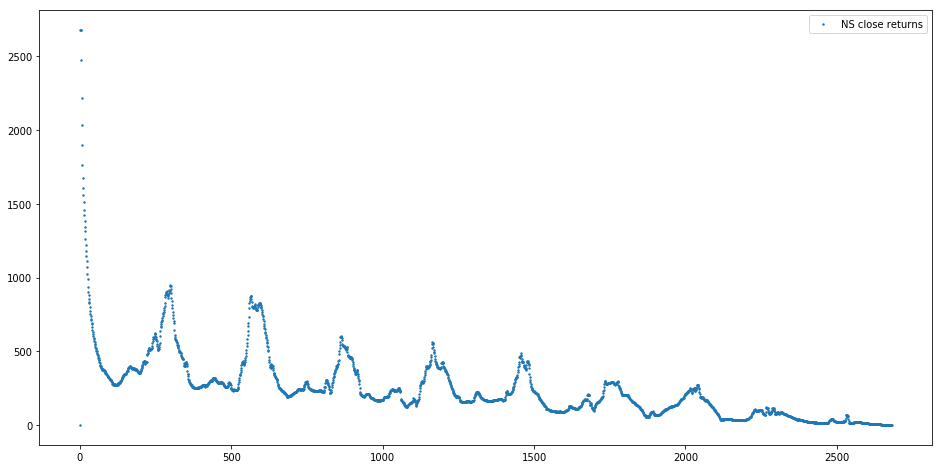

In [22]:
rt = NLDUtils.getCloseReturns(conv_NS[idxs][::2000].reshape(-1,1), get_mask=False)

rt_reordered = np.zeros(rt.shape)
for i in range(rt.shape[0]):
    for j in range(i, rt.shape[0]):
        rt_reordered[j - i, i] = rt[i, j]


trh = .5
reordered_mask = (rt_reordered < trh) & (rt_reordered > 0.)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.figure()
plt.scatter(np.arange(1, reordered_mask.shape[0]+1, 1), reordered_mask.sum(axis=1), s=2, label="NS close returns")
plt.legend()




In [23]:
%matplotlib qt5
%matplotlib qt5

In [24]:
plt.matshow(reordered_mask.astype(int))
plt.title("NS close returns")
plt.colorbar()
# plt.ylim([280, 260])
plt.gca().set_aspect('auto')

# Embeddings

In [68]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

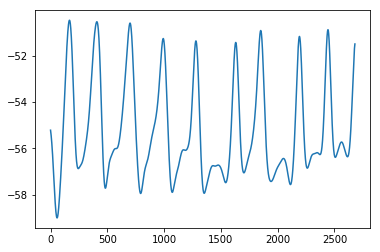

In [80]:
%matplotlib inline
step = 2000
plt.plot(conv_NS[idxs][::step])

In [82]:
step = 2000
NS_embedding = NLDUtils.getDerivativeEmbedding(trace=conv_NS[idxs][::step], dt=step/fs, emb_size=3)
# NS_embedding = NLDUtils.getDerivativeEmbedding(trace=conv_NS[::step], dt=step/fs, emb_size=3)

In [84]:
%matplotlib qt5
%matplotlib qt5
N = 21
cmap = plt.get_cmap('jet', N)

norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig = plt.figure()
ax = Axes3D(fig)
NS_plot =  NS_embedding
ax.scatter(NS_plot[:,0], NS_plot[:,1], NS_plot[:,2],c=plt.cm.jet(np.linspace(0, 2, NS_plot.shape[0])),s=5)

plt.colorbar(sm, ticks=np.linspace(0, 2, N),
             boundaries=np.arange(-0.05, 2.1, .1))

In [87]:
N = 21
cmap = plt.get_cmap('jet', N)

norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0, 2, N),
             boundaries=np.arange(-0.05, 2.1, .1))

fig = plt.figure()
ax = Axes3D(fig)
i=500
p = 620
ax.plot(NS_embedding[i:i+p, 0], NS_embedding[i:i+p, 1], NS_embedding[i:i+p, 2], label="n" + str(key) + " dt= " + str(i), lw=1)

In [72]:
cut_NS = conv_NS[np.where(time>crawling_interval[0])[0][0]: np.where(time<crawling_interval[1])[0][-1]]
cut_time = time[np.where(time>crawling_interval[0])[0][0]: np.where(time<crawling_interval[1])[0][-1]]
fig = burstUtils.plotFreq(smoothed_sfd, color_dict=burst_obj.color_dict, optional_trace=[cut_time[::2000], cut_NS[::2000]],
                    template_dict=burst_obj.template_dict, scatter_plot=False,
                    outlier_thres=None, ms=4)

In [71]:

burst_space = NLDUtils.generateOutputSpace(smoothed_sfd, cut_NS.T,fs)

sc = StandardScaler()
scaled_burst_space = sc.fit_transform(burst_space)

unitary, singular, v = NLDUtils.getPcaBase(scaled_burst_space.T, vect_num=5, plot_vectors=False)

proy = np.dot(scaled_burst_space, unitary)

(9, 2499) (2499,)


In [70]:
dim_size = 3
fig, ax = plt.subplots(dim_size, 1, sharex=True)
for i in range(dim_size):
    ax[i].plot(proy[:, i])
    ax[i].grid()


N = 21
cmap = plt.get_cmap('jet', N)

norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(proy[:, 0], proy[:, 1], proy[:, 2], c=plt.cm.jet(np.linspace(0, 2, proy.shape[0])), label='parametric curve', s=10)

plt.colorbar(sm, ticks=np.linspace(0, 2, N),
             boundaries=np.arange(-0.05, 2.1, .1))

In [68]:
emb = NLDUtils.getTraceEmbedding(trace=proy[:,0], step=8, emb_size=3)
N = 21
cmap = plt.get_cmap('jet', N)

norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(emb[:,0], emb[:,1], emb[:,2],c=plt.cm.jet(np.linspace(0, 2, emb.shape[0])),s=5)

plt.colorbar(sm, ticks=np.linspace(0, 2, N),
             boundaries=np.arange(-0.05, 2.1, .1))

In [66]:
emb.shape

(1734, 3, 9)